In [6]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_set = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_set = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [6]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [7]:
data = iter(train_set)
images, labels = data.next()


In [20]:
 for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        print(inputs.shape)
        print(labels.shape)
        break

torch.Size([4, 3, 32, 32])
torch.Size([4])


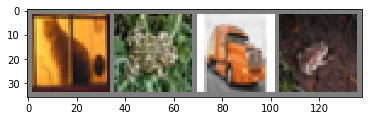

  cat  frog truck  frog


In [9]:
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

### Building a neural network

In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5) # flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [12]:
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [13]:
# loss function

In [16]:
loss_obj = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


In [18]:
EPOCHS = 2

In [19]:
for epoch in range(EPOCHS):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = loss_obj(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.254
[1,  4000] loss: 1.916
[1,  6000] loss: 1.705
[1,  8000] loss: 1.582
[1, 10000] loss: 1.510
[1, 12000] loss: 1.452
[2,  2000] loss: 1.377
[2,  4000] loss: 1.326
[2,  6000] loss: 1.320
[2,  8000] loss: 1.302
[2, 10000] loss: 1.289
[2, 12000] loss: 1.269
Finished Training


In [28]:
print(net.state_dict()['conv1.weight'].shape)# kernel
print(net.state_dict()['conv1.bias'].shape) # bias

torch.Size([6, 3, 5, 5])
torch.Size([6])


In [29]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

In [30]:
# testing

In [31]:
test_data_iter = iter(test_set)
image, labels = test_data_iter.next()

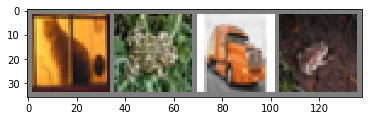

GroundTruth:    cat  ship  ship plane


In [32]:
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))


In [33]:
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [34]:
outputs = net(images)

In [37]:
_, predicted = torch.max(outputs, 1)

In [38]:
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  frog   cat  frog


In [39]:
# whole test set

In [40]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_set:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 55 %


In [41]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():# this is for inference mode
    for data in test_set:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))


Accuracy of plane : 59 %
Accuracy of   car : 62 %
Accuracy of  bird : 25 %
Accuracy of   cat : 57 %
Accuracy of  deer : 39 %
Accuracy of   dog : 37 %
Accuracy of  frog : 78 %
Accuracy of horse : 63 %
Accuracy of  ship : 74 %
Accuracy of truck : 61 %


## Second way

In [4]:
from torchsummary import summary

In [7]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=1),
            nn.ReLU(True),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1),
            nn.ReLU(True),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1),
            nn.ReLU(True),                           
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1),
            nn.ReLU(True),
            nn.BatchNorm2d(num_features=32),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(5, 5), padding=2),
            nn.ReLU(True),
            nn.Dropout2d(p=0.3)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1),
            nn.ReLU(True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=1),
            nn.ReLU(True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=1),
            nn.ReLU(True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(5, 5), padding=2),
            nn.ReLU(True),
            nn.Dropout2d(p=0.3)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1),
            nn.ReLU(True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=1),
            nn.ReLU(True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=1),
            nn.ReLU(True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=1),
            nn.ReLU(True),
            nn.BatchNorm2d(num_features=128),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(5, 5), padding=2),
            nn.ReLU(True),
            nn.Dropout2d(p=0.3)
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), padding=1),
            nn.ReLU(True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3), padding=1),
            nn.ReLU(True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3), padding=1),
            nn.ReLU(True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3), padding=1),
            nn.ReLU(True),
            nn.BatchNorm2d(num_features=256),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(5, 5), padding=2),
            nn.ReLU(True),
            nn.Dropout2d(p=0.3)
        )
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_features=1024, out_features=1024)
        self.fc1_dropout = nn.Dropout2d(p=0.3)
        self.fc2 = nn.Linear(in_features=1024, out_features=512)
        self.fc3 = nn.Linear(in_features=512, out_features=10)
        
        
    def forward(self, X):
        output = self.layer1(X)
        output = self.layer2(output)
        output = self.layer3(output)
        output = self.layer4(output)
        output = self.flatten(output)
        output = self.fc1(output)
        output = self.fc1_dropout(output)
        output = self.fc2(output)
        output = self.fc3(output)
        return output

In [8]:
model = Model()

In [9]:
print(model)

Model(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (11): ReLU(inplace=True)
    (12): Dropout2d(p=0.3, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=

In [10]:
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
            Conv2d-3           [-1, 32, 32, 32]           9,248
              ReLU-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           9,248
              ReLU-6           [-1, 32, 32, 32]               0
            Conv2d-7           [-1, 32, 32, 32]           9,248
              ReLU-8           [-1, 32, 32, 32]               0
       BatchNorm2d-9           [-1, 32, 32, 32]              64
        MaxPool2d-10           [-1, 32, 16, 16]               0
           Conv2d-11           [-1, 32, 16, 16]          25,632
             ReLU-12           [-1, 32, 16, 16]               0
        Dropout2d-13           [-1, 32, 16, 16]               0
           Conv2d-14           [-1, 64,